## SLV
La idea en SLV es que queremos mantener la dinámica de nuestro modelo de volatilidad estocástica, pero necesitamos ajustar la cantidad promedio de volatilidad que el modelo recoge en cada punto de la superficie S,t para que coincida con la cantidad del modelo de volatilidad local. Esto se logra agregando una función de apalancamiento, L (S, t) que aumenta la volatilidad que produce el modelo de volatilidad estocástica cuando subvalora las opciones de vainilla, y reduce la volatilidad cuando es demasiado alto (esto es bastante cercano a la relación entre las superficies de volatilidad que provienen del modelo de volatilidad local y el modelo de volatilidad estocática). Además, generalmente se agrega una fracción de mezcla η para calibrar entre el volatilidad local y estocástica con respecto a los valores exóticos del mercado que dependen del volatilidad del precio.

La dinámica risk-neutral es:

$ dS = rS(t)dt + \sqrt{\nu(t)}L(S,t)S(t)dW_{t}^S$
	
$ d\nu = \kappa(\theta-\nu(t))dt+\eta\varepsilon\sqrt{\nu(t)}dW_{t}^\nu$

Procedimiento de la calibración:

1-Tomar una superficie de volatilidad y calcular la LocalVol Dupire.

2-Calibrar un modelo de Heston lo mejor que se pueda.

3-Por último, pasar los dos modelos dentro del proceso de calibración L(S,t).

### Creación Funciones Útiles
Primero armamos unas funciones que nos seran utiles mas adelante

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import QuantLib as ql
import numpy as np
import pandas as pd
import itertools

from scipy.stats import norm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Algunas funciones utiles usadas mas adelante para ploter superficies de volatilidad 3D, 
# generar paths, y generar superficie de volatilidad apartir de parametros de Heston
def plot_vol_surface(
    vol_surface,
    plot_years=np.arange(0.1, 3, 0.1),
    plot_strikes=np.arange(70, 130, 1),
    funct="blackVol",
):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure()
    ax = fig.gca(projection="3d")
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array(
            [
                method_to_call(float(y), float(x))
                for xr, yr in zip(X, Y)
                for x, y in zip(xr, yr)
            ]
        ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0.1)

    fig.colorbar(surf, shrink=0.5, aspect=5)


def generate_multi_paths_df(sequence, num_paths):
    spot_paths = []
    vol_paths = []

    for i in range(num_paths):
        sample_path = seq.next()
        values = sample_path.value()

        spot, vol = values

        spot_paths.append([x for x in spot])
        vol_paths.append([x for x in vol])

    df_spot = pd.DataFrame(spot_paths, columns=[spot.time(x) for x in range(len(spot))])
    df_vol = pd.DataFrame(vol_paths, columns=[spot.time(x) for x in range(len(spot))])

    return df_spot, df_vol


def create_vol_surface_mesh_from_heston_params(
    today,
    calendar,
    spot,
    v0,
    kappa,
    theta,
    rho,
    sigma,
    rates_curve_handle,
    dividend_curve_handle,
    strikes=np.linspace(40, 200, 161),
    tenors=np.linspace(0.1, 3, 60),
):
    quote = ql.QuoteHandle(ql.SimpleQuote(spot))

    heston_process = ql.HestonProcess(
        rates_curve_handle, dividend_curve_handle, quote, v0, kappa, theta, sigma, rho
    )
    heston_model = ql.HestonModel(heston_process)
    heston_handle = ql.HestonModelHandle(heston_model)
    heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

    data = []
    for strike in strikes:
        data.append([heston_vol_surface.blackVol(tenor, strike) for tenor in tenors])

    expiration_dates = [
        calendar.advance(today, ql.Period(int(365 * t), ql.Days)) for t in tenors
    ]
    implied_vols = ql.Matrix(data)
    feller = 2 * kappa * theta - sigma ** 2

    return expiration_dates, strikes, implied_vols, feller


# Estado para el pricing de vanillas
spot = 100
rate = 0.0
today = ql.Date(1, 7, 2020)
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

# Seteamos una curva risk-free plana 
riskFreeCurve = ql.FlatForward(today, rate, ql.Actual365Fixed())

flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)


### Superficie de Volatilidad del Mercado

Creamos un plot de la superficie de volatilidades apartir de usar unos parámetros Random en un proceso de Heston (Supongamos que no conocemos los parámetros ni el proceso que la generaron)... Es decir hagamos de cuenta que es la superficie de volatilidad que nos muestra el mercado hoy

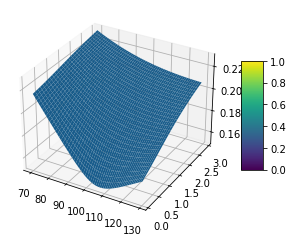

In [6]:
dates, strikes, vols, feller = create_vol_surface_mesh_from_heston_params(
    today, calendar, spot, 0.0225, 1.0, 0.0625, -0.25, 0.3, flat_ts, dividend_ts
)

local_vol_surface = ql.BlackVarianceSurface(
    today, calendar, dates, strikes, vols, day_count
)

# Ploteamo la vol surface 
plot_vol_surface(local_vol_surface)


### 1. Calculamos la volatilidad instantanea de Dupire

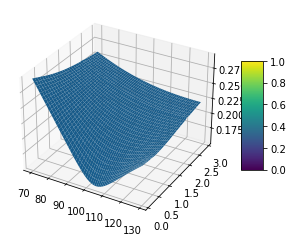

In [7]:
spot_quote = ql.QuoteHandle(ql.SimpleQuote(spot))

local_vol_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(local_vol_surface)
local_vol = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol.enableExtrapolation()

# Ploteamos la superficie de Dupire
plot_vol_surface(local_vol, funct="localVol")


### 2. Calibramos un proceso de Heston 

Asumamos que los parametros estan un poco mal, para poder mas adelante calibrar ambos modelos LV y SV con la función L(S,t). (De esta manera se verá mejor el efecto en el ejercicio)

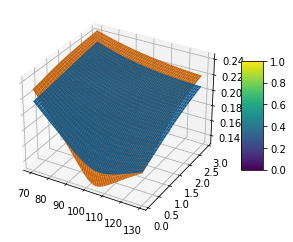

In [8]:
# Creamos un nuevo model de Heston
v0 = 0.015
kappa = 2.0
theta = 0.065
rho = -0.3
sigma = 0.45
spot = 1007
feller = 2 * kappa * theta - sigma ** 2

heston_process = ql.HestonProcess(
    flat_ts, dividend_ts, spot_quote, v0, kappa, theta, sigma, rho
)
heston_model = ql.HestonModel(heston_process)

# Como se ve la superficie de volatilidad?
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Ploteamos la primera superficie y también la nueva
plot_vol_surface([local_vol_surface, heston_vol_surface])


### 3. Ajustamos con la Volatilidad Local y calculamos la función de apalancamiento

Calibrar la funcion de apalancamiento L(S,t) depende de un parámetro numérico de accuracy que se llama calibrationPath. Por default viene 2**15, corre rápido pero produce una función puntiaguda... mientras más grande este número más suave la función, aunque nos podemos quedar sin memoria.

Paths: 32768
calibration took 27.2 seconds


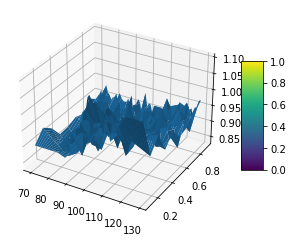

Paths: 131072
calibration took 80.4 seconds


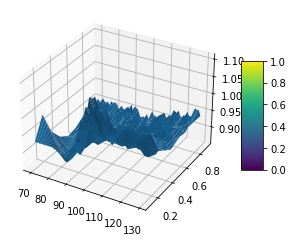

Paths: 524288
calibration took 265.7 seconds


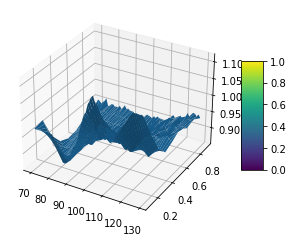

Paths: 1048576
calibration took 584.1 seconds


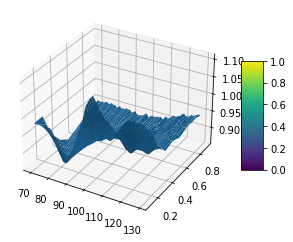

In [9]:
# Calibramos via Monte-Carlo
import time

end_date = ql.Date(1, 7, 2021)
generator_factory = ql.MTBrownianGeneratorFactory(43)

calibration_paths_vars = [2 ** 15, 2 ** 17, 2 ** 19, 2 ** 20]
time_steps_per_year, n_bins = 365, 201

for calibration_paths in calibration_paths_vars:
    print("Paths: {}".format(calibration_paths))
    stoch_local_mc_model = ql.HestonSLVMCModel(
        local_vol,
        heston_model,
        generator_factory,
        end_date,
        time_steps_per_year,
        n_bins,
        calibration_paths,
    )

    a = time.time()
    leverage_functon = stoch_local_mc_model.leverageFunction()
    b = time.time()

    print("calibration took {0:2.1f} seconds".format(b - a))
    plot_vol_surface(
        leverage_functon, funct="localVol", plot_years=np.arange(0.1, 0.98, 0.1)
    )
    plt.pause(0.05)


Creamos un generador de paths, y generamos paths a partir del proceso SLV que creamos arriba.

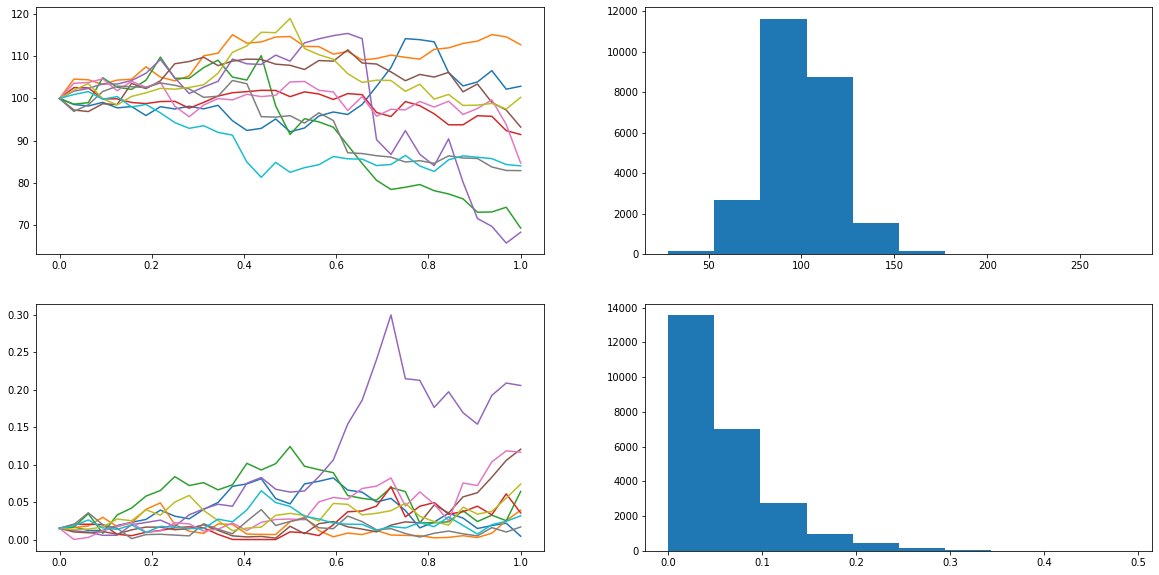

In [10]:
num_paths = 25000
timestep = 32
length = 1
times = ql.TimeGrid(length, timestep)

stoch_local_process = ql.HestonSLVProcess(heston_process, leverage_functon)
dimension = stoch_local_process.factors()

rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(dimension * timestep, ql.UniformRandomGenerator())
)
seq = ql.GaussianMultiPathGenerator(stoch_local_process, list(times), rng, False)

df_spot, df_vol = generate_multi_paths_df(seq, num_paths)

fig = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(df_spot.iloc[0:10].transpose())

plt.subplot(2, 2, 2)
plt.hist(df_spot[1.0])

plt.subplot(2, 2, 3)
plt.plot(df_vol.iloc[0:10].transpose())

plt.subplot(2, 2, 4)
plt.hist(df_vol[1.0])

plt.show()


### 4. Pricear la opción.
Podemos pricear la opción via Montecarlo con los paths generados.

In [13]:
# Call un año a strike 100
(df_spot[1.0] - 100).clip(lower=0).mean()

7.22263467933447